In [46]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterator, Tuple, TypeVar, Sequence, List, Mapping
from operator import itemgetter
import itertools
from rl.distribution import Distribution, Choose
from rl.function_approx import FunctionApprox, Dynamic, Tabular
from rl.iterate import iterate, converged
from rl.markov_process import (FiniteMarkovRewardProcess, MarkovRewardProcess,
                               RewardTransition, NonTerminal, State)
from rl.markov_decision_process import (FiniteMarkovDecisionProcess,
                                        MarkovDecisionProcess,
                                        StateActionMapping)
from rl.policy import Policy, DeterministicPolicy
from rl.approximate_dynamic_programming import value_iteration, evaluate_mrp
from rl.distribution import Categorical, Choose
from rl.dynamic_programming import policy_iteration_result

# Assignment 4
https://github.com/joshkmartinez/RL-book/tree/master/A4

# 1

In [82]:
S = TypeVar('S')
A = TypeVar('A')
V = Mapping[NonTerminal[S], float]

ValueFunctionApprox = FunctionApprox[NonTerminal[S]]
QValueFunctionApprox = FunctionApprox[Tuple[NonTerminal[S], A]]
NTStateDistribution = Distribution[NonTerminal[S]]

def policy_iteration(
    mdp: MarkovDecisionProcess[S, A],
    γ: float,
    approx_0: Tuple[ValueFunctionApprox[S], FinitePolicy[S, A]]
) -> Iterator[ValueFunctionApprox[S]]:

    def update(v_p: Tuple[ValueFunctionApprox[S], FinitePolicy[S, A]]) -> Tuple[ValueFunctionApprox[S], FiniteDeterministicPolicy[S, A]]:

        v, pi = v_p # tuple decomposition
        policies = {}
        policy_v: ValueFunctionApprox[S] = evaluate_finite_mrp(mdp.apply_finite_policy(pi), γ, v)

        for state in mdp.non_terminal_states:
            q_values: Iterator[Tuple[A, float]] = ((a, mdp.mapping[state][a].expectation(
                    lambda s_r: s_r[1] + γ * extended_v(v, s_r[0])
                )) for a in mdp.actions(state))
            policies[state] = max(q_values, key=itemgetter(1))[0]
 

        return policy_v, FiniteDeterministicPolicy(policies)

    return iterate(update, approx_0)

# 2
$$\text{Expected Utility }E[U(x)] \newline
E[U(x)]= E[x - \frac{\alpha x^2}{2}] = E[x] - \frac{\alpha}{2}E[x^2]
\newline
E[U(x)] = \mu - \frac{\alpha}{2}(\sigma^2+\mu^2)
\\[0.5in]
\text{Certainty-Equivalent Value } x_{CE} \newline
U(x_{CE}) = E[U(x)] \newline x_{CE} = U^{-1}(E[U(x)])
\newline
0 = \frac{\alpha x_{CE}^2}{2} - x_{CE} + \mu - \frac{\alpha}{2} (\mu^2 + \sigma^2)
\newline
x_{CE} = \frac{1}{\alpha} \left(1 \pm \sqrt{1 - \alpha(2\mu - \alpha(\mu^2 + \sigma^2))}\right)
\\[0.5in]
\text{Absolute Risk-Premium }\pi_A \newline
\pi_A = E[x] − x_{CE}
\newline
\pi_A = \mu - \frac{\alpha}{2}(\mu^2 + \sigma^2) - \frac{1}{\alpha} \left(1 \pm \sqrt{1 - \alpha(2\mu - \alpha(\mu^2 + \sigma^2))}\right).
\\[0.5in]
\text{To optimize } z \text{ given } \alpha \text{, we maximize } x_{CE}
\newline
\frac{\partial x_{CE}}{\partial \pi} \implies \pi^* =  \frac{(1-\alpha r)(\mu - r)}{2\alpha ((\mu - r)^2 + \sigma^2)}
\newline
\therefore Z^* = 1000000 \times  \frac{(1-\alpha r)(\mu - r)}{2\alpha ((\mu - r)^2 + \sigma^2)}
\newline
$$

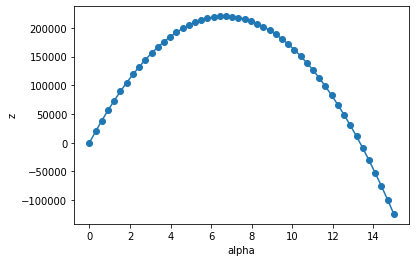

In [7]:
mu = 0.2
sigma = 0.3 ** 2
risk_free_return = 0.075

z_s = lambda mu, sigma, risk_free_return, alpha : 10000000 * (1 - alpha * risk_free_return) * (mu - risk_free_return) / 2 * alpha * ((mu - risk_free_return)**2 + sigma)

alpha = np.linspace(0.0, 15)
z = z_s(mu, sigma, risk_free_return, alpha)

plt.plot(alpha, z)
plt.scatter(alpha, z)

plt.xlabel("alpha")
plt.ylabel("z")
plt.show()

# 3

$$ \text{The 2 outcomes of W after a single bet are: } W_0(1+f \cdot \alpha) \text{ and } W_0(1-f \cdot \beta)
\newline
log(W_1) = log(W_0) + \begin{cases}
log(1+f \cdot \alpha)\\
log(1-f \cdot \beta)
\end{cases}
\newline
E[log(W_1)] = log(W_0)+p \cdot log(1+f\cdot \alpha) + (1-p)(1-f\cdot \beta)
\newline
\frac{\partial E[log(W_1)]}{\partial f} = \frac{p \cdot \alpha}{1+f\cdot \alpha} - \frac{(1-p) \cdot \beta}{1-f\cdot \beta}
\newline
\implies f^* = \frac{p}{\beta} - \frac{1-p}{\alpha}
$$
This makes intuative sense since if your probability of winning is lower, you want to invest less, and vice versa for investing more if your probabilty of winning is higher.